<a href="https://colab.research.google.com/github/mrzResearchArena/Anticancer-Peptides-CNN/blob/master/Codes/ACP-740-single-head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [1]. Google Drive Initialization:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd 'drive/My Drive/ACP-PyFeat'

/content/drive/My Drive/ACP-PyFeat


In [4]:
ls

bit-in-689.npy   blosum-740.npy      bpf-val-172.npy
bit-in-776.npy   blosum-in-689.npy   bpf-val-194.npy
bits-164.npy     blosum-in-776.npy   model-240.png
bits-240.npy     blosum-val-172.npy  model-240-single-head.png
bits-500.npy     blosum-val-194.npy  model-500-164.png
bits-740.npy     bpf-164.npy         model-740.png
bit-val-172.npy  bpf-240.npy         model-single-Head-500-164.png
bit-val-194.npy  bpf-500.npy         ROC-240.png
blosum-164.npy   bpf-740.npy         ROC-500-164.png
blosum-240.npy   bpf-in-689.npy      ROC-740.png
blosum-500.npy   bpf-in-776.npy      ROC.png


### [2]. Load Deep Learning API (Keras):

In [5]:
# # Initialize TF-2.x:
# try:
#     %tensorflow_version 2.x  # Colab only.
# except Exception:
#     pass

# import tensorflow as tf
# print('We\'re using TF-{}.'.format(tf.__version__))

# # Colab Auto Click: [https://paste.ubuntu.com/p/R78fGBJbjb/]

In [6]:
# Deep Neural Networks:
import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
# import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)
from tensorflow.keras.regularizers import (l1, l2, l1_l2)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from tensorflow.keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.patches as patches

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score, roc_curve, auc)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical as labelEncoding   # Usages: Y = labelEncoding(Y, dtype=int)
from tensorflow.keras.utils import plot_model                        # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)

#end-import

We're using TF-2.5.0.


In [7]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['accuracy'], label='Training Accuracy')
    plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

In [8]:
def rocPlot(TPR, meanFPR):
    plt.plot([0,1], [0,1],linestyle = '--',lw = 2,color = 'black')
    meanTPR = np.mean(TPR, axis=0)
    meanAUC = auc(meanFPR, meanTPR)
    plt.plot(meanFPR, meanTPR, color='blue',
            label=r'Mean ROC (AUC = %0.2f )' % (meanAUC),lw=2, alpha=1)

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
    plt.legend(loc="lower right")
    plt.savefig('ROC-240.png')
    plt.show()
#end-def

### [3]. Load Datasets:

In [19]:
T = 15 # terminus_length

X1 = np.load('bpf-740.npy')
X2 = np.load('bits-740.npy')
X3 = np.load('blosum-740.npy')


X1 = X1[:,0:T,:]
X2 = X2[:,0:T,:]
X3 = X3[:,0:T,:]


Y  = [1 for _ in range(376)]
Y += [0 for _ in range(364)]

Y = labelEncoding(Y, dtype=int)


print(X1.shape)
print(X2.shape)
print(X3.shape)
print(Y.shape)

(740, 15, 20)
(740, 15, 31)
(740, 15, 20)
(740, 2)


In [20]:
def globalFeatureConcat(X1, X2, X3):
    V = []
    for x1,x2,x3 in zip(X1, X2, X3):
        v = np.concatenate((x1, x2, x3), axis=1)
        V.append(v)
    #end-for
    return np.array(V)

X = globalFeatureConcat(X1, X2, X3)
print(X.shape)

(740, 15, 71)


### [4]. Generate Model:

In [22]:
### Model-740

def Network():
    ### Head-1:
    input1 = Input(shape=X[0].shape)

    x = Conv1D(filters=10, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head1 = Flatten()(x)

    output = Dense(units=8, activation='relu', kernel_regularizer=l2(l=0.01))(head1)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.70)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1], outputs=[output])
#end-def

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 15, 71)]          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 15, 10)            2850      
_________________________________________________________________
batch_normalization_36 (Batc (None, 15, 10)            40        
_________________________________________________________________
dropout_36 (Dropout)         (None, 15, 10)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 15, 8)             248       
_________________________________________________________________
batch_normalization_37 (Batc (None, 15, 8)             32        
_________________________________________________________________
dropout_37 (Dropout)         (None, 15, 8)             0  

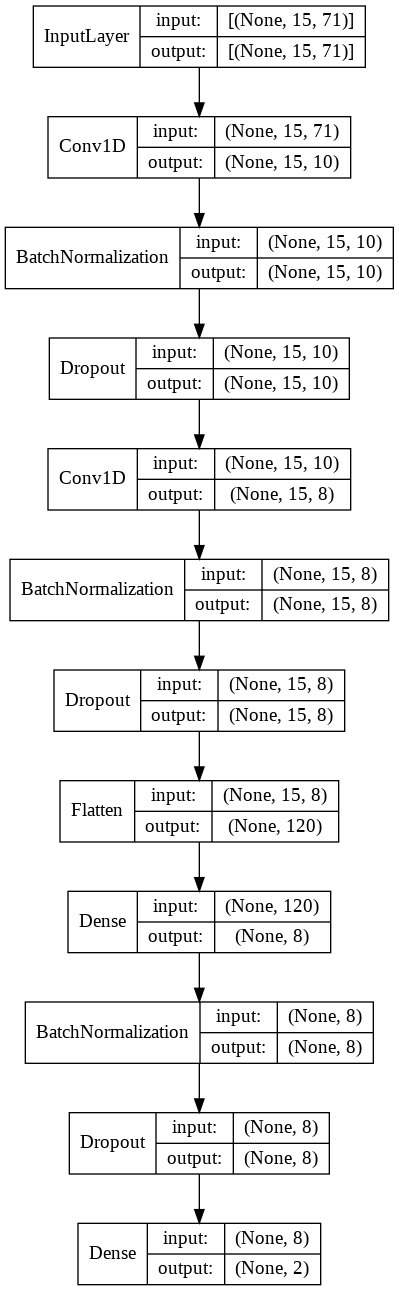

In [23]:
model = Network()
model.summary()
plot_model(model, to_file='model-740-single-head.png', show_shapes=True, show_layer_names=False, expand_nested=True)

### [5]. Run Model:

Epoch 1/500
74/74 [==============================] - 1s 7ms/step - loss: 1.3852 - accuracy: 0.4932 - val_loss: 1.0512 - val_accuracy: 0.5811
Epoch 2/500
74/74 [==============================] - 0s 4ms/step - loss: 1.1090 - accuracy: 0.5253 - val_loss: 1.0191 - val_accuracy: 0.5135
Epoch 3/500
74/74 [==============================] - 0s 5ms/step - loss: 1.0104 - accuracy: 0.5068 - val_loss: 0.9674 - val_accuracy: 0.5068
Epoch 4/500
74/74 [==============================] - 0s 4ms/step - loss: 0.9585 - accuracy: 0.5135 - val_loss: 0.9250 - val_accuracy: 0.4730
Epoch 5/500
74/74 [==============================] - 0s 4ms/step - loss: 0.9065 - accuracy: 0.5068 - val_loss: 0.8871 - val_accuracy: 0.4730
Epoch 6/500
74/74 [==============================] - 0s 5ms/step - loss: 0.8798 - accuracy: 0.5118 - val_loss: 0.8690 - val_accuracy: 0.4865
Epoch 7/500
74/74 [==============================] - 0s 4ms/step - loss: 0.8546 - accuracy: 0.5287 - val_loss: 0.8420 - val_accuracy: 0.5068
Epoch 8/500
7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
74/74 [==============================] - 2s 7ms/step - loss: 1.6494 - accuracy: 0.5405 - val_loss: 1.0497 - val_accuracy: 0.6419
Epoch 2/500
74/74 [==============================] - 0s 4ms/step - loss: 1.2482 - accuracy: 0.5236 - val_loss: 1.0462 - val_accuracy: 0.6419
Epoch 3/500
74/74 [==============================] - 0s 4ms/step - loss: 1.1140 - accuracy: 0.4730 - val_loss: 1.0184 - val_accuracy: 0.5000
Epoch 4/500
74/74 [==============================] - 0s 4ms/step - loss: 1.0065 - accuracy: 0.4713 - val_loss: 0.9813 - val_accuracy: 0.3919
Epoch 5/500
74/74 [==============================] - 0s 4ms/step - loss: 0.9518 - accuracy: 0.5541 - val_loss: 0.9363 - val_accuracy: 0.5811
Epoch 6/500
74/74 [==============================] - 0s 4ms/step - loss: 0.9275 - accuracy: 0.5101 - val_loss: 0.9168 - val_accuracy: 0.3919
Epoch 7/500
74/74 [==============================] - 0s 5ms/step - loss: 0.8866 - accuracy: 0.5541 - val_loss: 0.8938 - val_accuracy: 0.3986
Epoch 8/500
7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
74/74 [==============================] - 1s 7ms/step - loss: 1.3430 - accuracy: 0.5321 - val_loss: 1.0695 - val_accuracy: 0.4865
Epoch 2/500
74/74 [==============================] - 0s 5ms/step - loss: 1.1299 - accuracy: 0.5034 - val_loss: 1.0135 - val_accuracy: 0.5473
Epoch 3/500
74/74 [==============================] - 0s 5ms/step - loss: 1.0050 - accuracy: 0.4679 - val_loss: 0.9581 - val_accuracy: 0.5405
Epoch 4/500
74/74 [==============================] - 0s 5ms/step - loss: 0.9420 - accuracy: 0.4459 - val_loss: 0.9103 - val_accuracy: 0.5541
Epoch 5/500
74/74 [==============================] - 0s 5ms/step - loss: 0.8945 - accuracy: 0.4983 - val_loss: 0.8704 - val_accuracy: 0.5135
Epoch 6/500
74/74 [==============================] - 0s 5ms/step - loss: 0.8606 - accuracy: 0.5034 - val_loss: 0.8424 - val_accuracy: 0.5270
Epoch 7/500
74/74 [==============================] - 0s 5ms/step - loss: 0.8334 - accuracy: 0.5084 - val_loss: 0.8250 - val_accuracy: 0.5135
Epoch 8/500
7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
74/74 [==============================] - 1s 7ms/step - loss: 1.5849 - accuracy: 0.5169 - val_loss: 1.0748 - val_accuracy: 0.5743
Epoch 2/500
74/74 [==============================] - 0s 4ms/step - loss: 1.2471 - accuracy: 0.5152 - val_loss: 1.0430 - val_accuracy: 0.6014
Epoch 3/500
74/74 [==============================] - 0s 4ms/step - loss: 1.0728 - accuracy: 0.5321 - val_loss: 0.9935 - val_accuracy: 0.5878
Epoch 4/500
74/74 [==============================] - 0s 5ms/step - loss: 0.9970 - accuracy: 0.5236 - val_loss: 0.9541 - val_accuracy: 0.5743
Epoch 5/500
74/74 [==============================] - 0s 4ms/step - loss: 0.9575 - accuracy: 0.5000 - val_loss: 0.9189 - val_accuracy: 0.6284
Epoch 6/500
74/74 [==============================] - 0s 4ms/step - loss: 0.9018 - accuracy: 0.5304 - val_loss: 0.8831 - val_accuracy: 0.6216
Epoch 7/500
74/74 [==============================] - 0s 4ms/step - loss: 0.8763 - accuracy: 0.5372 - val_loss: 0.8586 - val_accuracy: 0.6014
Epoch 8/500
7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
74/74 [==============================] - 1s 7ms/step - loss: 1.5407 - accuracy: 0.4645 - val_loss: 1.1112 - val_accuracy: 0.5676
Epoch 2/500
74/74 [==============================] - 0s 5ms/step - loss: 1.1616 - accuracy: 0.4797 - val_loss: 1.0254 - val_accuracy: 0.6014
Epoch 3/500
74/74 [==============================] - 0s 5ms/step - loss: 1.0175 - accuracy: 0.5422 - val_loss: 0.9751 - val_accuracy: 0.5878
Epoch 4/500
74/74 [==============================] - 0s 5ms/step - loss: 0.9643 - accuracy: 0.5220 - val_loss: 0.9269 - val_accuracy: 0.6689
Epoch 5/500
74/74 [==============================] - 0s 5ms/step - loss: 0.9074 - accuracy: 0.5625 - val_loss: 0.8850 - val_accuracy: 0.6149
Epoch 6/500
74/74 [==============================] - 0s 5ms/step - loss: 0.8874 - accuracy: 0.5726 - val_loss: 0.8511 - val_accuracy: 0.6351
Epoch 7/500
74/74 [==============================] - 0s 5ms/step - loss: 0.8438 - accuracy: 0.5878 - val_loss: 0.8308 - val_accuracy: 0.6554
Epoch 8/500
7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


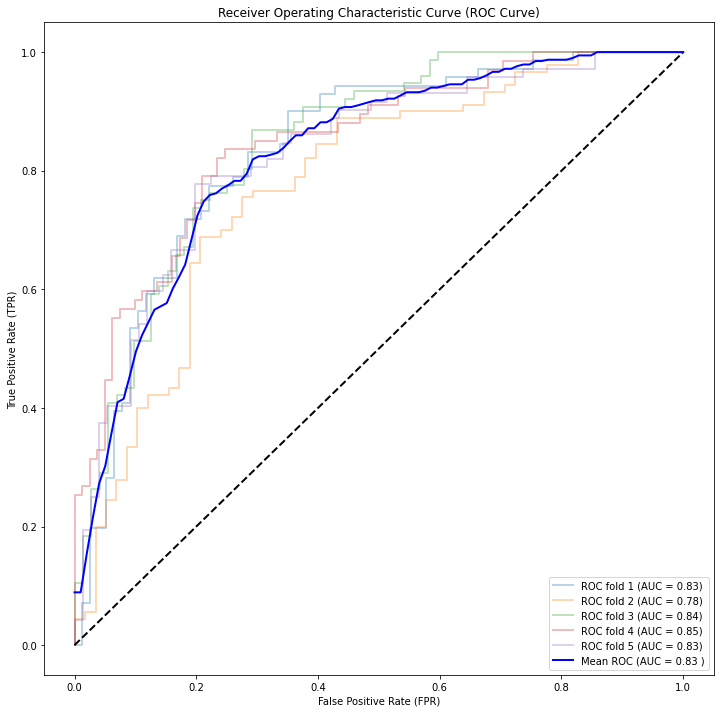

Accuracy [Each Fold]: [0.7702702879905701, 0.7229729890823364, 0.7432432174682617, 0.7905405163764954, 0.7297297120094299]
Accuracy: 0.75
Sensitivity: 0.8012
Specificity: 0.7031
MCC: 0.5134
Precision: 0.7433


In [25]:
setEpochNumber     = 500     # Performed-welled in epoch 600.
setBatchSizeNumber = 8
####################################################

cv = KFold(n_splits=5, shuffle=True, random_state=101)

Accuracy = []
Sensitivity = []
Specificity = []
Precision = []
MCC = []

# ROC Curve:
fig1 = plt.figure(figsize=[12,12])

TPR = []
meanFPR = np.linspace(0, 1, 100)

i = 1

for train, test in cv.split(Y):

    # Compile Model:
    model = Network()
    model.compile(optimizer=Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Run Model:
    results = model.fit(x=X[train,:,:],
                        y=Y[train,:],
                        validation_data=(X[test,:,:], Y[test,:]),
                        batch_size=setBatchSizeNumber, epochs=setEpochNumber,
                        verbose=1,
                        callbacks=[])
    
    accuracy = model.evaluate(x=X[test,:,:], y=Y[test,:], batch_size=setBatchSizeNumber)
    Accuracy.append(accuracy[1])

    # Performance Metices:
    Yactual = Y[test,:].argmax(axis=1)
    Yp = model.predict(X[test,:,:])
    v = Yp
    Yp = Yp.argmax(axis=1)

    CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
    TN, FP, FN, TP = CM.ravel()

    MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
    Sensitivity.append( TP / (TP + FN) )
    Specificity.append( TN / (TN + FP) )
    Precision.append(precision_score(y_true=Yactual, y_pred=Yp))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(Yactual, v[:,1])
    TPR.append(interp(meanFPR, fpr, tpr))
    rocauc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, rocauc))
    i= i+1
    
    # # Performance Plot
    # print('#################################################')
    # print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
    # lossPlot(results)
    # accuracyPlot(results)
    # print('#################################################')

    
#end-for

rocPlot(TPR, meanFPR)

print('Accuracy [Each Fold]: {}'.format(Accuracy))
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))
print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/5.00))
print('Specificity: {0:.4f}'.format(np.sum(Specificity)/5.00))
print('MCC: {0:.4f}'.format(np.sum(MCC)/5.00))
print('Precision: {0:.4f}'.format(np.sum(Precision)/5.00))